Analysis of image factors on annotation consensus-- Zooniverse
Start date: 09/26/2023

In [2]:
#Imports
import pandas as pd
from PIL import Image
import os
import ast
import numpy as np

In [42]:
#Analysis annotations
path = "E:\\imagefactors\\data\\consensusLabels_agreementIndex.csv"
with open(path) as f:
  df = pd.read_csv(f)

#Fixing how bounding boxes are read for the analysis labels
def eval_bbox_refined(row):
    if pd.notnull(row['consensus_bbox']):
        return ast.literal_eval(row['consensus_bbox'])
    else:
        return None
# Apply the function to the 'bbox_refined' column and save the results
df['consensus_bbox'] = df.apply(eval_bbox_refined, axis=1)

#Creating a base file column to match tiles to full images later
df["basefile"] = [x[:-10] for x in df['filename']]

df.head()

,id,filename,consensus_class_ID,consensus_bbox,pielou_index,basefile
0,1,20211201_Atrisco_0459_01_01.png,Goose,"[634.05224609375, 260.4735412597656, 49.0, 80....",0.764205,20211201_Atrisco_0459
1,2,20211201_Atrisco_0459_01_01.png,Goose,"[555.4261474609375, 216.25, 53.0, 69.0]",0.764205,20211201_Atrisco_0459
2,3,20211201_Atrisco_0459_01_01.png,Goose,"[266.75, 120.83124542236328, 60.33087158203125...",0.764205,20211201_Atrisco_0459
3,4,20211201_Atrisco_0459_01_01.png,Goose,"[176.8125, 22.46035385131836, 52.0, 84.0]",0.764205,20211201_Atrisco_0459
4,5,20211201_Atrisco_0459_01_01.png,Goose,"[101.36946105957031, 170.06580352783203, 62.24...",0.721928,20211201_Atrisco_0459


In [ ]:
#IF RESUMING FROM A SAVED POINT
path = "E:/imagefactors/data/crowdsourced_imagefactors.csv"
with open(path) as f:
  df = pd.read_csv(f)
#Fixing how bounding boxes are read for the analysis labels
def eval_bbox_refined(row):
    if pd.notnull(row['consensus_bbox']):
        return ast.literal_eval(row['consensus_bbox'])
    else:
        return None
# Apply the function to the 'bbox_refined' column and save the results
df['consensus_bbox'] = df.apply(eval_bbox_refined, axis=1)

In [43]:
#Calculate area of bboxes
def calc_area(row):
    bbox = row['consensus_bbox']
    xmin, ymin, w, h = bbox
    return w * h

df['area'] = df.apply(calc_area, axis=1)

In [44]:
# Define a function to calculate percentage area
def calculate_percentage_area(image_filename, bbox_area):
    image_path = os.path.join("E:\\imagefactors\\data\\zooniverse", image_filename)
    
    try:
        image = Image.open(image_path)
    except FileNotFoundError:
        # Handle the case where the image is not found
        print(f"Image not found: {image_path}")
        return None  # You can return a special value, such as None, to indicate the image wasn't found
    
    image_width, image_height = image.size
    image_area = image_width * image_height

    percentage_area = (bbox_area / image_area) * 100
    return percentage_area

# Calculate percentage area and add it as a new
df['bbox_percent_area'] = df.apply(lambda row: calculate_percentage_area(row['filename'], row['area']), axis=1)

df.head()

,id,filename,consensus_class_ID,consensus_bbox,pielou_index,basefile,area,bbox_percent_area
0,1,20211201_Atrisco_0459_01_01.png,Goose,"[634.05224609375, 260.4735412597656, 49.0, 80....",0.764205,20211201_Atrisco_0459,3920.061310,1.100016
1,2,20211201_Atrisco_0459_01_01.png,Goose,"[555.4261474609375, 216.25, 53.0, 69.0]",0.764205,20211201_Atrisco_0459,3657.000000,1.026198
2,3,20211201_Atrisco_0459_01_01.png,Goose,"[266.75, 120.83124542236328, 60.33087158203125...",0.764205,20211201_Atrisco_0459,5188.454956,1.455943
3,4,20211201_Atrisco_0459_01_01.png,Goose,"[176.8125, 22.46035385131836, 52.0, 84.0]",0.764205,20211201_Atrisco_0459,4368.000000,1.225713
4,5,20211201_Atrisco_0459_01_01.png,Goose,"[101.36946105957031, 170.06580352783203, 62.24...",0.721928,20211201_Atrisco_0459,5135.498171,1.441082


In [45]:
# % of targets of the same class in the same image, as the analysis target

# Define a function to calculate the percentage of same-class neighbors for a given row
def calculate_same_class_percentage(row, df):
    # Get the filename and class ID of the target bounding box
    filename = row['filename']
    class_id = row['consensus_class_ID']
    
    # Filter the DataFrame to include only rows with matching filenames
    matching_rows = df[df['filename'] == filename]
    
    # Calculate the total number of neighbors in the same image
    total_neighbors = len(matching_rows) - 1  # Subtract 1 to exclude the target bounding box
    
    if total_neighbors == 0:
        return 0  # Avoid division by zero
    
    # Calculate the number of same-class neighbors
    same_class_neighbors = len(matching_rows[matching_rows['consensus_class_ID'] == class_id]) - 1  # Subtract 1 to exclude the target bounding box
    
    # Calculate the percentage of same-class neighbors
    same_class_percentage = (same_class_neighbors / total_neighbors) * 100
    
    return same_class_percentage

# Calculate the same-class percentage for each row and add the results as a new column
df['same_class_percent'] = df.apply(lambda row: calculate_same_class_percentage(row, df), axis=1)

In [47]:
#How many neighbors for each annotation?

# Define a function to calculate the number of neighbors for a given row
def count_neighbors(row, df):
    # Extract 'bbox' values from the 'consensus_bbox' column as a list [xmin, ymin, width, height]
    bbox = row['consensus_bbox']  # Use ast.literal_eval() to safely evaluate the string
    
    # Define the search radius as 2 times the maximum of width and height
    search_radius = 2 * max(bbox[2], bbox[3])
    
    # Calculate the center coordinates of the bounding box
    x_center = bbox[0] + bbox[2] / 2
    y_center = bbox[1] + bbox[3] / 2
    
    # Initialize a count for neighbors
    num_neighbors = 0
    
    # Iterate through rows with matching filenames
    matching_rows = df[df['filename'] == row['filename']]
    
    for _, neighbor_row in matching_rows.iterrows():
        if neighbor_row.name != row.name:
            # Extract 'bbox' values for the neighbor as a list [xmin, ymin, width, height]
            neighbor_bbox = neighbor_row['consensus_bbox']
            
            # Calculate the center coordinates of the potential neighbor
            neighbor_x_center = neighbor_bbox[0] + neighbor_bbox[2] / 2
            neighbor_y_center = neighbor_bbox[1] + neighbor_bbox[3] / 2
            
            # Calculate the Euclidean distance between centers
            distance = np.sqrt((x_center - neighbor_x_center)**2 + (y_center - neighbor_y_center)**2)
            
            # Check if the neighbor is within the search radius
            if distance <= search_radius:
                num_neighbors += 1
    
    return num_neighbors

# Calculate the number of neighbors for each row and add the results as a new column
df['num_neighbors'] = df.apply(lambda row: count_neighbors(row, df), axis=1)

df.head()

,id,filename,consensus_class_ID,consensus_bbox,pielou_index,basefile,area,bbox_percent_area,same_class_percent,num_neighbors
0,1,20211201_Atrisco_0459_01_01.png,Goose,"[634.05224609375, 260.4735412597656, 49.0, 80....",0.764205,20211201_Atrisco_0459,3920.061310,1.100016,100.0,1
1,2,20211201_Atrisco_0459_01_01.png,Goose,"[555.4261474609375, 216.25, 53.0, 69.0]",0.764205,20211201_Atrisco_0459,3657.000000,1.026198,100.0,1
2,3,20211201_Atrisco_0459_01_01.png,Goose,"[266.75, 120.83124542236328, 60.33087158203125...",0.764205,20211201_Atrisco_0459,5188.454956,1.455943,100.0,4
3,4,20211201_Atrisco_0459_01_01.png,Goose,"[176.8125, 22.46035385131836, 52.0, 84.0]",0.764205,20211201_Atrisco_0459,4368.000000,1.225713,100.0,2
4,5,20211201_Atrisco_0459_01_01.png,Goose,"[101.36946105957031, 170.06580352783203, 62.24...",0.721928,20211201_Atrisco_0459,5135.498171,1.441082,100.0,1


In [11]:
path1 = "E:\\imagefactors\\data\\crowdsourced_gsd.csv"
with open(path1) as f1:
  gsd_df = pd.read_csv(f1)

gsd_df["basefile"] = gsd_df["filename"].apply(lambda x: os.path.splitext(x)[0])

merged_df = pd.merge(df, gsd_df, on="basefile", how="left")
merged_df = merged_df.rename(columns={"filename_x": "filename"})
merged_df = merged_df.drop(columns=["filename_y", "filename_base"])
merged_df.head()

,id,filename,consensus_class_ID,consensus_bbox,pielou_index,basefile,area,bbox_percent_area,same_class_percent,num_neighbors,agl,gsd
0,1,20211201_Atrisco_0459_01_01.png,Goose,"[634.05224609375, 260.4735412597656, 49.0, 80....",0.764205,20211201_Atrisco_0459,3920.061310,1.100016,100.0,1,30.0,0.678024
1,2,20211201_Atrisco_0459_01_01.png,Goose,"[555.4261474609375, 216.25, 53.0, 69.0]",0.764205,20211201_Atrisco_0459,3657.000000,1.026198,100.0,1,30.0,0.678024
2,3,20211201_Atrisco_0459_01_01.png,Goose,"[266.75, 120.83124542236328, 60.33087158203125...",0.764205,20211201_Atrisco_0459,5188.454956,1.455943,100.0,4,30.0,0.678024
3,4,20211201_Atrisco_0459_01_01.png,Goose,"[176.8125, 22.46035385131836, 52.0, 84.0]",0.764205,20211201_Atrisco_0459,4368.000000,1.225713,100.0,2,30.0,0.678024
4,5,20211201_Atrisco_0459_01_01.png,Goose,"[101.36946105957031, 170.06580352783203, 62.24...",0.721928,20211201_Atrisco_0459,5135.498171,1.441082,100.0,1,30.0,0.678024


In [12]:
#Distance from image center

# Function to calculate distance from center
def calculate_distance_from_center(row):
    image_path = os.path.join("E:\\imagefactors\\data\\zooniverse", row["filename"])
    
    try:
        image = Image.open(image_path)
    except FileNotFoundError:
        # Handle the case where the image is not found
        print(f"Image not found: {image_path}")
        return None  # You can return a special value, such as None, to indicate the image wasn't found
    
    image_width, image_height = image.size
    center_x_px = image_width/2 
    center_y_px = image_height/2
    gsd_m = row['gsd'] / 100

    row['center_x_m'] = center_x_px * gsd_m
    row['center_y_m'] = center_y_px * gsd_m
    
    # Get the coordinates of the bounding box (x, y, width, height)
    x, y, width, height = row['consensus_bbox']

    # Calculate the center point of the bounding box in pixels
    bbox_center_x_px = x + (width / 2)
    bbox_center_y_px = y + (height / 2)

    # Calculate the center point of the bounding box in meters
    bbox_center_x_m = bbox_center_x_px * gsd_m
    bbox_center_y_m = bbox_center_y_px * gsd_m

    # Calculate the distance from the center of the image in meters
    distance_m = ((row['center_x_m'] - bbox_center_x_m)**2 + (row['center_y_m'] - bbox_center_y_m)**2)**0.5

    return distance_m

# Apply the function to the merged dataframe
merged_df['distance_from_center'] = merged_df.apply(calculate_distance_from_center, axis=1)
merged_df.head()

,id,filename,consensus_class_ID,consensus_bbox,pielou_index,basefile,area,bbox_percent_area,same_class_percent,num_neighbors,agl,gsd,distance_from_center
0,1,20211201_Atrisco_0459_01_01.png,Goose,"[634.05224609375, 260.4735412597656, 49.0, 80....",0.764205,20211201_Atrisco_0459,3920.061310,1.100016,100.0,1,30.0,0.678024,2.163344
1,2,20211201_Atrisco_0459_01_01.png,Goose,"[555.4261474609375, 216.25, 53.0, 69.0]",0.764205,20211201_Atrisco_0459,3657.000000,1.026198,100.0,1,30.0,0.678024,1.628098
2,3,20211201_Atrisco_0459_01_01.png,Goose,"[266.75, 120.83124542236328, 60.33087158203125...",0.764205,20211201_Atrisco_0459,5188.454956,1.455943,100.0,4,30.0,0.678024,0.723215
3,4,20211201_Atrisco_0459_01_01.png,Goose,"[176.8125, 22.46035385131836, 52.0, 84.0]",0.764205,20211201_Atrisco_0459,4368.000000,1.225713,100.0,2,30.0,0.678024,1.630146
4,5,20211201_Atrisco_0459_01_01.png,Goose,"[101.36946105957031, 170.06580352783203, 62.24...",0.721928,20211201_Atrisco_0459,5135.498171,1.441082,100.0,1,30.0,0.678024,1.459121


In [34]:
df.to_csv('E:/imagefactors/data/crowdsourced_imagefactors.csv', index=False)

In [104]:
import os
import cv2
import pandas as pd
from skimage.feature import graycomatrix, graycoprops
import numpy as np
import ast

def calculate_gclm_derivatives(image, bbox):
    # Convert bounding box coordinates to integers
    x, y, width, height = map(int, bbox)
    
    # Extract the region of interest (ROI) from the image using the bounding box
    roi = image[y:y+height, x:x+width]
    
    # Convert the ROI to grayscale
    roi_gray = cv2.cvtColor(roi, cv2.COLOR_RGB2GRAY)
    
    # Calculate GCLM features for the grayscale ROI
    distances = [1, 2]  # Define the distances for GCLM
    angles = [0, np.pi/4, np.pi/2, 3*np.pi/4]  # Define the angles for GCLM
    gclm = graycomatrix(roi_gray, distances=distances, angles=angles, levels=256,
                        symmetric=True, normed=True)
    
    # Calculate GCLM derivatives (contrast, dissimilarity, homogeneity, energy)
    contrast = graycoprops(gclm, 'contrast').mean()
    dissimilarity = graycoprops(gclm, 'dissimilarity').mean()
    homogeneity = graycoprops(gclm, 'homogeneity').mean()
    energy = graycoprops(gclm, 'energy').mean()
    
    return contrast, dissimilarity, homogeneity, energy

def calculate_texture_metrics_for_csv(image_path, csv_file):
        # Load the image
        image = cv2.imread(image_path)
        
        # Read the CSV file
        csv_data = pd.read_csv(csv_file)
        
        # Find the corresponding image filename
        image_filename = os.path.basename(image_path)
        
        # Filter annotations based on the image filename
        annotations = csv_data[csv_data['filename'] == image_filename]
        
        # Initialize lists to store the texture metrics
        bbox_contrast_list = []
        bbox_dissimilarity_list = []
        bbox_homogeneity_list = []
        bbox_energy_list = []
        donut_contrast_list = []
        donut_dissimilarity_list = []
        donut_homogeneity_list = []
        donut_energy_list = []
        
        # Iterate through annotations and calculate texture metrics
        for _, row in annotations.iterrows():
            bbox = ast.literal_eval(row['consensus_bbox'])  # Parse bbox values from string to list
            
            # Calculate GCLM derivatives for bounding box and donut region
            bbox_contrast, bbox_dissimilarity, bbox_homogeneity, bbox_energy = calculate_gclm_derivatives(image, bbox)
            
            donut_left = max(0, bbox[0] - 20)  # Adjust the buffer size as needed
            donut_top = max(0, bbox[1] - 20)
            donut_right = min(image.shape[1], bbox[0] + bbox[2] + 20)
            donut_bottom = min(image.shape[0], bbox[1] + bbox[3] + 20)
            donut_bbox = [donut_left, donut_top, donut_right - donut_left, donut_bottom - donut_top]
            donut_contrast, donut_dissimilarity, donut_homogeneity, donut_energy = calculate_gclm_derivatives(image, donut_bbox)
            
            # Append the calculated texture metrics to the lists
            bbox_contrast_list.append(bbox_contrast)
            bbox_dissimilarity_list.append(bbox_dissimilarity)
            bbox_homogeneity_list.append(bbox_homogeneity)
            bbox_energy_list.append(bbox_energy)
            
            donut_contrast_list.append(donut_contrast)
            donut_dissimilarity_list.append(donut_dissimilarity)
            donut_homogeneity_list.append(donut_homogeneity)
            donut_energy_list.append(donut_energy)
        
        # Add texture metrics as new columns in the dataframe
        annotations['bbox_contrast'] = bbox_contrast_list
        annotations['bbox_dissimilarity'] = bbox_dissimilarity_list
        annotations['bbox_homogeneity'] = bbox_homogeneity_list
        annotations['bbox_energy'] = bbox_energy_list
        
        annotations['donut_contrast'] = donut_contrast_list
        annotations['donut_dissimilarity'] = donut_dissimilarity_list
        annotations['donut_homogeneity'] = donut_homogeneity_list
        annotations['donut_energy'] = donut_energy_list
        
        # Save the modified dataframe if needed
        annotations.to_csv('E:\\imagefactors\\data\\gclm.csv', index=False)
    
# Example usage
image_path = 'E:\\imagefactors\\data\\zooniverse\\20211212_Alameda_0285_07_08.png'
csv_file = path  # Replace with the actual path to your CSV file containing the annotations

calculate_texture_metrics_for_csv(image_path, csv_file)

C:\Users\rconverse\AppData\Local\Temp\ipykernel_7096\1269721627.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  annotations['bbox_contrast'] = bbox_contrast_list
C:\Users\rconverse\AppData\Local\Temp\ipykernel_7096\1269721627.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  annotations['bbox_dissimilarity'] = bbox_dissimilarity_list
C:\Users\rconverse\AppData\Local\Temp\ipykernel_7096\1269721627.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try u

In [105]:
import os
import cv2
import pandas as pd
from skimage.feature import graycomatrix, graycoprops
import numpy as np
import ast

def calculate_gclm_derivatives(image, bbox):
    # Convert bounding box coordinates to integers
    x, y, width, height = map(int, bbox)
    
    # Extract the region of interest (ROI) from the image using the bounding box
    roi = image[y:y+height, x:x+width]
    
    # Check if the ROI is empty or None
    if roi is None or roi.size == 0:
        print("Warning: ROI is empty or None")
        return None, None, None, None
    
    # Convert the ROI to grayscale
    roi_gray = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)
    
    # Calculate GCLM features for the grayscale ROI
    distances = [1, 2]  # Define the distances for GCLM
    angles = [0, np.pi/4, np.pi/2, 3*np.pi/4]  # Define the angles for GCLM
    gclm = graycomatrix(roi_gray, distances=distances, angles=angles, levels=256,
                        symmetric=True, normed=True)
    
    # Calculate GCLM derivatives (contrast, dissimilarity, homogeneity, energy)
    contrast = graycoprops(gclm, 'contrast').mean()
    dissimilarity = graycoprops(gclm, 'dissimilarity').mean()
    homogeneity = graycoprops(gclm, 'homogeneity').mean()
    energy = graycoprops(gclm, 'energy').mean()
    
    return contrast, dissimilarity, homogeneity, energy

def calculate_texture_metrics_for_directory(image_dir, csv_file):
    # Initialize an empty dataframe to store the texture metrics
    texture_metrics_df = pd.DataFrame()
    
    # List all files in the specified directory
    image_files = [f for f in os.listdir(image_dir) if os.path.isfile(os.path.join(image_dir, f))]
    
    for image_file in image_files:
        try:
            # Construct the full path to the image file
            image_path = os.path.join(image_dir, image_file)
            
            # Load the image
            image = cv2.imread(image_path)
            
            if image is None:
                print(f"Warning: Image '{image_path}' not found or cannot be loaded.")
                continue
            
            # Read the CSV file
            csv_data = pd.read_csv(csv_file)
            
            # Find the corresponding image filename
            image_filename = os.path.basename(image_path)
            
            # Filter annotations based on the image filename
            annotations = csv_data[csv_data['filename'] == image_filename]
            
            # Initialize lists to store the texture metrics
            bbox_contrast_list = []
            bbox_dissimilarity_list = []
            bbox_homogeneity_list = []
            bbox_energy_list = []
            donut_contrast_list = []
            donut_dissimilarity_list = []
            donut_homogeneity_list = []
            donut_energy_list = []
            
            # Iterate through annotations and calculate texture metrics
            for _, row in annotations.iterrows():
                bbox = ast.literal_eval(row['consensus_bbox'])  # Parse bbox values from string to list
                
                # Calculate GCLM derivatives for bounding box and donut region
                bbox_contrast, bbox_dissimilarity, bbox_homogeneity, bbox_energy = calculate_gclm_derivatives(image, bbox)
                
                donut_left = max(0, bbox[0] - 20)  # Adjust the buffer size as needed
                donut_top = max(0, bbox[1] - 20)
                donut_right = min(image.shape[1], bbox[0] + bbox[2] + 20)
                donut_bottom = min(image.shape[0], bbox[1] + bbox[3] + 20)
                donut_bbox = [donut_left, donut_top, donut_right - donut_left, donut_bottom - donut_top]
                donut_contrast, donut_dissimilarity, donut_homogeneity, donut_energy = calculate_gclm_derivatives(image, donut_bbox)
                
                # Append the calculated texture metrics to the lists
                bbox_contrast_list.append(bbox_contrast)
                bbox_dissimilarity_list.append(bbox_dissimilarity)
                bbox_homogeneity_list.append(bbox_homogeneity)
                bbox_energy_list.append(bbox_energy)
                
                donut_contrast_list.append(donut_contrast)
                donut_dissimilarity_list.append(donut_dissimilarity)
                donut_homogeneity_list.append(donut_homogeneity)
                donut_energy_list.append(donut_energy)
            
            # Add texture metrics as columns to a temporary dataframe
            temp_df = pd.DataFrame({
                'filename': [image_filename] * len(annotations),
                'bbox_contrast': bbox_contrast_list,
                'bbox_dissimilarity': bbox_dissimilarity_list,
                'bbox_homogeneity': bbox_homogeneity_list,
                'bbox_energy': bbox_energy_list,
                'donut_contrast': donut_contrast_list,
                'donut_dissimilarity': donut_dissimilarity_list,
                'donut_homogeneity': donut_homogeneity_list,
                'donut_energy': donut_energy_list
            })
            
            # Append the temporary dataframe to the main dataframe
            texture_metrics_df = pd.concat([texture_metrics_df, temp_df], ignore_index=True)
        except Exception as e:
            print(f"Error processing image '{image_path}': {e}")
    
    # Save the main dataframe with texture metrics to a CSV file
    texture_metrics_df.to_csv('E:\\imagefactors\\data\\gclm.csv', index=False)

# Example usage with a directory containing images
image_dir = 'E:\\imagefactors\\data\\zooniverse'
csv_file = path  # Replace with the actual path to your CSV file containing the annotations

calculate_texture_metrics_for_directory(image_dir, csv_file)

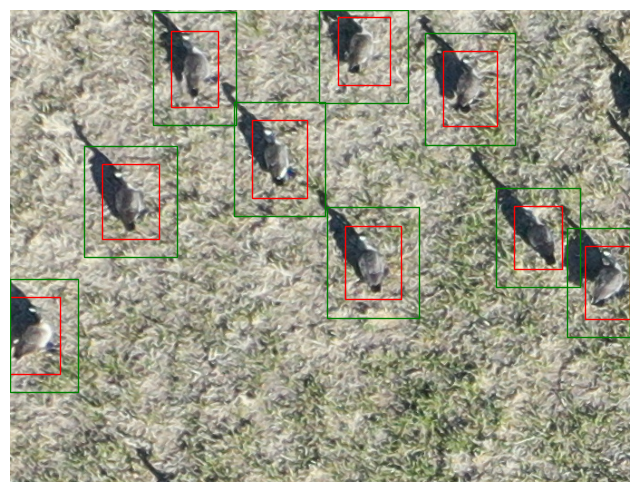

In [72]:
#Sample visualization of donut + bounding boxes just to make sure it all looks good

import os
import cv2
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

def visualize_bounding_boxes_with_donuts(image_path, csv_file):
    # Load the image
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert from BGR to RGB
    
    # Read the CSV file
    csv_data = pd.read_csv(csv_file)
    
    # Find the corresponding image filename
    image_filename = os.path.basename(image_path)
    
    # Filter annotations based on the image filename
    annotations = csv_data[csv_data['filename'] == image_filename]
    
    # Plot the image with bounding boxes and donut regions
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.imshow(image)
    ax.axis('off')
    
    # Iterate through annotations and draw bounding boxes and donut regions
    for _, row in annotations.iterrows():
        bbox = ast.literal_eval(row['consensus_bbox'])  # Parse bbox values from string to list
        
        # Draw bounding box
        rectangle = Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3], linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rectangle)
        
        # Draw donut region
        donut_left = max(0, bbox[0] - 20)  # Adjust the buffer size as needed
        donut_top = max(0, bbox[1] - 20)
        donut_right = min(image.shape[1], bbox[0] + bbox[2] + 20)
        donut_bottom = min(image.shape[0], bbox[1] + bbox[3] + 20)
        donut_rectangle = Rectangle((donut_left, donut_top), (donut_right - donut_left),
                                   (donut_bottom - donut_top), linewidth=1, edgecolor='g', facecolor='none')
        ax.add_patch(donut_rectangle)
    
    # Show the plot
    plt.show()

# Example usage
image_path = 'E:\\imagefactors\\data\\zooniverse\\20211201_Atrisco_0459_01_01.png'
csv_file = path

visualize_bounding_boxes_with_donuts(image_path, csv_file)


In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm


In [21]:
rows_with_missing_data = merged_df[merged_df['pielou_index'].isnull() | merged_df['gsd'].isnull()]

len(rows_with_missing_data)

10910

In [26]:
nogsd = merged_df[merged_df['gsd'].isnull()]
nogsd["basefile"].unique()

array(['BDA_12C_20181127_1', 'BDA_12C_20181127_2', 'BDA_12C_20181127_3',
       'BDA_18A4_20181106_1', 'BDA_18A4_20181106_2',
       'BDA_18A4_20181106_3', 'BDA_18A4_20181106_4',
       'BDA_18A4_20181107_1', 'BDA_18A4_20181107_2',
       'BDA_18A4_20181107_3', 'BDA_18A4_20181107_4',
       'FWS_MaxwellLake13_20171215_1_00456',
       'FWS_MaxwellLake13_20171215_1_00457',
       'FWS_MaxwellLake13_20171215_1_00462',
       'FWS_MaxwellLake13_20171215_1_00463',
       'FWS_MaxwellLake13_20171215_1_00464',
       'FWS_MaxwellLake13_20171215_1_00465',
       'FWS_MaxwellLake13_20171215_1_00466',
       'FWS_MaxwellLake13_20171215_1_00467',
       'FWS_MaxwellLake13_20171215_1_00468',
       'FWS_MaxwellLake13_20171215_1_00475',
       'FWS_MaxwellLake13_20171215_1_00476',
       'FWS_MaxwellLake13_20171215_1_00477',
       'FWS_MaxwellLake13_20171215_1_00478',
       'FWS_MaxwellLake13_20171215_1_00479',
       'FWS_MaxwellLake13_20171215_1_00480',
       'FWS_MaxwellLake13_20171215_1_004

In [28]:
df = merged_df.dropna(subset=['pielou_index', 'gsd'])

In [33]:
df['density'] = df.groupby('filename')['consensus_bbox'].transform('count')
df.head()

C:\Users\rconverse\AppData\Local\Temp\ipykernel_12840\3414395078.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['density'] = df.groupby('filename')['consensus_bbox'].transform('count')


,id,filename,consensus_class_ID,consensus_bbox,pielou_index,basefile,area,bbox_percent_area,same_class_percent,num_neighbors,agl,gsd,distance_from_center,density
0,1,20211201_Atrisco_0459_01_01.png,Goose,"[634.05224609375, 260.4735412597656, 49.0, 80....",0.764205,20211201_Atrisco_0459,3920.061310,1.100016,100.0,1,30.0,0.678024,2.163344,9
1,2,20211201_Atrisco_0459_01_01.png,Goose,"[555.4261474609375, 216.25, 53.0, 69.0]",0.764205,20211201_Atrisco_0459,3657.000000,1.026198,100.0,1,30.0,0.678024,1.628098,9
2,3,20211201_Atrisco_0459_01_01.png,Goose,"[266.75, 120.83124542236328, 60.33087158203125...",0.764205,20211201_Atrisco_0459,5188.454956,1.455943,100.0,4,30.0,0.678024,0.723215,9
3,4,20211201_Atrisco_0459_01_01.png,Goose,"[176.8125, 22.46035385131836, 52.0, 84.0]",0.764205,20211201_Atrisco_0459,4368.000000,1.225713,100.0,2,30.0,0.678024,1.630146,9
4,5,20211201_Atrisco_0459_01_01.png,Goose,"[101.36946105957031, 170.06580352783203, 62.24...",0.721928,20211201_Atrisco_0459,5135.498171,1.441082,100.0,1,30.0,0.678024,1.459121,9


In [29]:
#Simple linear regression 

y = df['pielou_index']
X = df['gsd']

# Add a constant term to the independent variable (intercept)
X = sm.add_constant(X)

# Fit the linear regression model
model = sm.OLS(y, X).fit()

# Print the regression summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:           pielou_index   R-squared:                       0.050
Model:                            OLS   Adj. R-squared:                  0.050
Method:                 Least Squares   F-statistic:                     7152.
Date:                Tue, 03 Oct 2023   Prob (F-statistic):               0.00
Time:                        14:02:11   Log-Likelihood:                -35629.
No. Observations:              136447   AIC:                         7.126e+04
Df Residuals:                  136445   BIC:                         7.128e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0720      0.002     32.625      0.0

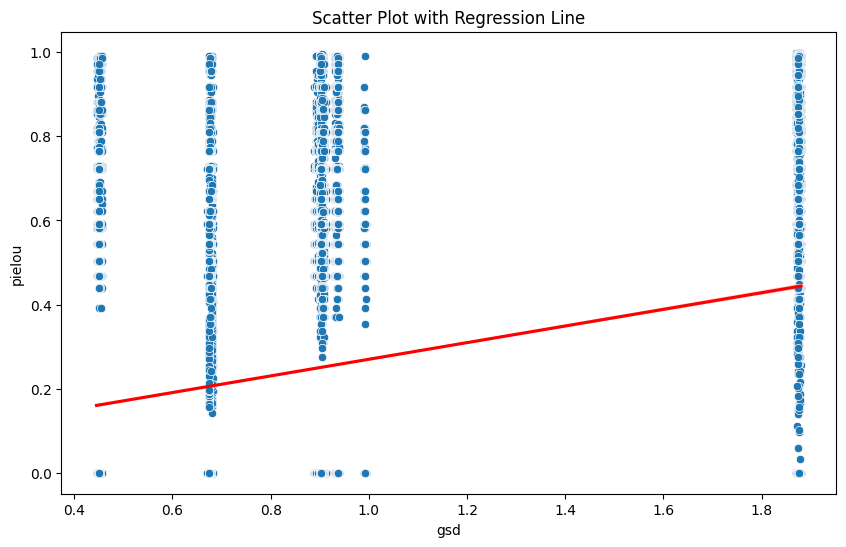

In [31]:
# Create a scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x='gsd', y='pielou_index', data=df)

# Add the regression line
sns.regplot(x='gsd', y='pielou_index', data=df, scatter=False, color='red')

plt.title('Scatter Plot with Regression Line')
plt.xlabel('gsd')
plt.ylabel('pielou')
plt.show()


In [2]:
import csv

# Function to calculate the average GSD from a CSV file
def calculate_average_gsd(csv_file_path):
    gsd_values = []
    with open(csv_file_path, mode='r') as csv_file:
        csv_reader = csv.DictReader(csv_file)
        for row in csv_reader:
            gsd_cm = float(row.get("GSD (cm)", 0))  # Get the GSD value and convert to float
            gsd_values.append(gsd_cm)
    
    # Calculate the average GSD
    if gsd_values:
        average_gsd = sum(gsd_values) / len(gsd_values)
    else:
        average_gsd = 0.0  # Default value when no GSD values are available
    
    return average_gsd

# Paths to the two CSV files to compare
csv_file_path_1 = 'E:\\imagefactors\\data\\benchmark_gsd.csv'
csv_file_path_2 = 'E:\\imagefactors\\data\\crowdsourced_gsd.csv'

# Calculate the average GSD for both files
average_gsd_1 = calculate_average_gsd(csv_file_path_1)
average_gsd_2 = calculate_average_gsd(csv_file_path_2)

# Compare and print the results
if average_gsd_1 > average_gsd_2:
    print(f"Average GSD in CSV file 1 is greater: {average_gsd_1} cm, compared to {average_gsd_2}")
elif average_gsd_1 < average_gsd_2:
    print(f"Average GSD in CSV file 2 is greater: {average_gsd_2} cm, compared to {average_gsd_1}")
else:
    print(f"Average GSDs in both CSV files are equal: {average_gsd_1} cm")

Average GSD in CSV file 2 is greater: 0.9447141533589504 cm, compared to 0.6651000213166498
